In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import rasterio
import tqdm
import pandas as pd
import rasterio
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as v2
import torchvision.models as models
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchsummary import summary

from terratorch.models.pixel_wise_model import freeze_module
from huggingface_hub import hf_hub_download
from terratorch.models.backbones.prithvi_mae import PrithviViT

In [2]:
def set_seed(seed):
    torch.manual_seed(seed) # Set seed for Python's built-in random number generator
    np.random.seed(seed) # Set seed for numpy
    if torch.cuda.is_available(): # Set seed for CUDA if available
        torch.cuda.manual_seed_all(seed)
        # Set cuDNN's random number generator seed for deterministic behavior
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [3]:
class prithvi_terratorch(nn.Module):
  def __init__(self, prithvi_weight, model_instance, input_size):
    super(prithvi_terratorch, self).__init__()
    # load checkpoint for Prithvi_global
    self.weights_path = prithvi_weight
    self.checkpoint = torch.load(self.weights_path)
    self.input_size = input_size
    self.prithvi_model = model_instance   
    self.prithvi_model.load_state_dict(self.checkpoint, strict=False)

  def freeze_encoder(self):
    freeze_module(self.prithvi_model)

  def forward(self,x,temp,loc,mask):
    latent,_,ids_restore = self.prithvi_model.forward(x,temp,loc,mask)
    return latent

In [4]:
def load_raster(path, if_img=1, crop=None):
  with rasterio.open(path) as src:
    img = src.read(out_dtype=np.float32)
    # load  selected 4 bands for Sentinnel 2 (S2)
    if if_img==1:
      bands=[0,1,2,3]
      img = img[bands,:,:]
    # img = np.where(img == NO_DATA, NO_DATA_FLOAT, img)# update our NO_DATA with -0.9999 -- chips are already scaled
    # print("img size",img.shape) 
    if crop:
      img = img[:, -crop[0]:, -crop[1]:]
  # print('return from load ras')
  return img

def preprocess_image(image, means, stds):        
    # normalize image
    means1 = means.reshape(-1,1,1)  # Mean across height and width, for each channel
    stds1 = stds.reshape(-1,1,1)    # Std deviation across height and width, for each channel
    normalized = ((image - means1) / stds1)
    normalized = torch.from_numpy(normalized).to(torch.float32)
    #normalized = torch.from_numpy(normalized.reshape(1, normalized.shape[0], 1, *normalized.shape[-2:])).to(torch.float32)
    #print('return from norm')
    return normalized

In [42]:
class TestDataset(Dataset):
    def __init__(self, dir_sentinel, dir_landsat, dir_bioclim, metadata, subset, num_classes=None, transform_sentinel=None, transform_landsat=None,
                 mean_sentinel=np.array([0.0]), std_sentinel=np.array([1.0])):
        self.subset = subset
        self.transform_sentinel = transform_sentinel
        self.mean_sentinel = np.array(mean_sentinel)
        self.std_sentinel = np.array(std_sentinel)
        self.transform_landsat = transform_landsat
        self.dir_sentinel = dir_sentinel
        self.dir_landsat = dir_landsat
        self.dir_bioclim = dir_bioclim
        self.metadata = metadata
        self.num_classes = num_classes
        if self.subset == "test":
            self.landsat_file_sep = "_"
        elif self.subset == "train":
            self.landsat_file_sep = "-"

    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        survey_id = self.metadata.surveyId[idx]
        lonlat = torch.tensor(self.metadata.loc[idx, ["lon","lat"]].values.astype(np.float32))
        path_landsat = os.path.join(self.dir_landsat, f"GLC25-PA-{self.subset}-landsat{self.landsat_file_sep}time{self.landsat_file_sep}series_{survey_id}_cube.pt")
        sample_landsat = torch.nan_to_num(torch.load(path_landsat, weights_only=True)[:,:,:landsat_year_len])
        if self.transform_landsat:
            sample_landsat = self.transform_landsat(sample_landsat)
        path_bioclim = os.path.join(self.dir_bioclim, f"GLC25-PA-{self.subset}-bioclimatic_monthly_{survey_id}_cube.pt")
        sample_bioclim = torch.nan_to_num(torch.load(path_bioclim, weights_only=True))
        #print(sample_bioclim.shape)
        tmp1 = torch.reshape(sample_bioclim, [4,-1])
        tmp2 = torch.reshape(torch.cat([tmp1[:,:1], tmp1[:,:bioclim_month_len]], axis=-1), [4,landsat_year_len,4,3])
        sample_bioclim_new = torch.permute(torch.mean(tmp2, -1), [0,2,1])[:2] 
        sample_bioclim_new = (sample_bioclim_new - np.array([0,2730])[:,None,None]) / np.array([5000,300])[:,None,None]
        #print(sample_bioclim_new.shape)
        sample_landsat = torch.cat([sample_landsat, sample_bioclim_new], 0)
        #print(sample_landsat.shape)
        dir1, dir2 = str(survey_id)[-2:], str(survey_id)[-4:-2]        
        path_sentinel = os.path.join(self.dir_sentinel, dir1, dir2, f"{survey_id}.tiff")
        image_sentinel = preprocess_image(load_raster(path_sentinel) / 1e4, self.mean_sentinel, self.std_sentinel)
        sample_sentinel = torch.nan_to_num(image_sentinel)
        if self.transform_sentinel:
            sample_sentinel = self.transform_sentinel(sample_sentinel)
        return sample_sentinel, sample_landsat, lonlat, survey_id

class TrainDataset(TestDataset):
  def __init__(self, dir_sentinel, dir_landsat, dir_bioclim, metadata, subset, num_classes, transform_sentinel=None, transform_landsat=None,
              mean_sentinel=np.array([0.0]), std_sentinel=np.array([1.0])):
    super(TrainDataset, self).__init__(dir_sentinel, dir_landsat, dir_bioclim, metadata, subset, num_classes, transform_sentinel, transform_landsat,
              mean_sentinel, std_sentinel)
    self.metadata = self.metadata.dropna(subset="speciesId").reset_index(drop=True)
    self.metadata['speciesId'] = self.metadata['speciesId'].astype(int)
    self.label_dict = self.metadata.groupby('surveyId')['speciesId'].apply(list).to_dict()
    self.metadata = self.metadata.drop_duplicates(subset="surveyId").reset_index(drop=True)

  def __getitem__(self, idx):
    sample_sentinel, sample_landsat, lonlat, survey_id = super(TrainDataset, self).__getitem__(idx)
    species_ids = self.label_dict.get(survey_id, [])  # Get list of species IDs for the survey ID
    label = torch.zeros(self.num_classes).scatter(0, torch.tensor(species_ids), torch.ones(len(species_ids)))
    return sample_sentinel, sample_landsat, lonlat, label, survey_id

train size:  80088  | validation size:  8899
torch.Size([4, 64, 64])


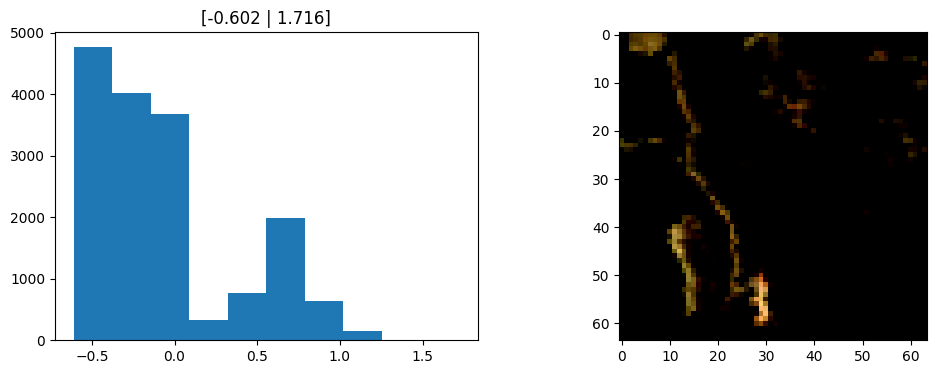

torch.Size([4, 64, 64])


In [43]:
batch_size = 64
num_workers = 4
num_classes = 11255
landsat_year_len = 18
bioclim_month_len = landsat_year_len*12-1
mean_sentinel = [0.1]
std_sentinel = [0.13]
validation_prop = 0.1
transform_landsat = v2.Compose([
    # v2.RandomRotation(180)
])

transform_sentinel = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(180)
])

# Load Training metadata
set_seed(42)
path_data = "/home/gt/DATA/geolifeclef-2025"
train_path_sentinel = os.path.join(path_data, "SatelitePatches/PA-train")
train_path_landsat = os.path.join(path_data, "SateliteTimeSeries-Landsat/cubes/PA-train")
train_path_bioclim = os.path.join(path_data, "BioclimTimeSeries/cubes/PA-train")
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata_groups = list(train_metadata.groupby("surveyId"))
#val_ind = np.sort(np.random.choice(train_metadata.shape[0], np.round(train_metadata.shape[0] / 10).astype(int), replace=False))
val_ind = np.sort(train_metadata.surveyId.drop_duplicates().sample(frac=validation_prop).values)
#val_row = train_metadata.surveyId.isin(val_ind)
#val_metadata = train_metadata.loc[val_row]
#train_metadata = train_metadata.loc[~val_row]
train_metadata, val_metadata = [x for _, x in train_metadata.groupby(train_metadata.surveyId.isin(val_ind))]
train_dataset = TrainDataset(train_path_sentinel, train_path_landsat, train_path_bioclim, train_metadata, subset="train", num_classes=num_classes, transform_sentinel=transform_sentinel,
                            mean_sentinel=mean_sentinel, std_sentinel=std_sentinel)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataset = TrainDataset(train_path_sentinel, train_path_landsat, train_path_bioclim, val_metadata, subset="train", num_classes=num_classes, transform_sentinel=transform_sentinel,
                            mean_sentinel=mean_sentinel, std_sentinel=std_sentinel)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print("train size: ", len(train_dataset), " | validation size: ", len(val_dataset))
print(train_dataset[0][0].shape)
plt.figure(figsize=[12,4])
plt.subplot(1, 2, 1)
plt.hist(train_dataset[0][0].flatten())
plt.title("[%.3f | %.3f]" % (np.min(train_dataset[0][0].numpy()), np.max(train_dataset[0][0].numpy())))
plt.subplot(1, 2, 2)
plt.imshow(torch.permute(train_dataset[0][0][:3], [1,2,0]))
plt.show()


# Load Test metadata
test_path_sentinel = os.path.join(path_data, "SatelitePatches/PA-test")
test_path_landsat = os.path.join(path_data, "SateliteTimeSeries-Landsat/cubes/PA-test")
test_path_bioclim = os.path.join(path_data, "BioclimTimeSeries/cubes/PA-test")
test_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_test.csv"))
test_dataset = TestDataset(test_path_sentinel, test_path_landsat, test_path_bioclim, test_metadata, subset="test", transform_sentinel=None,
                          mean_sentinel=mean_sentinel, std_sentinel=std_sentinel)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print(test_dataset[0][0].shape)

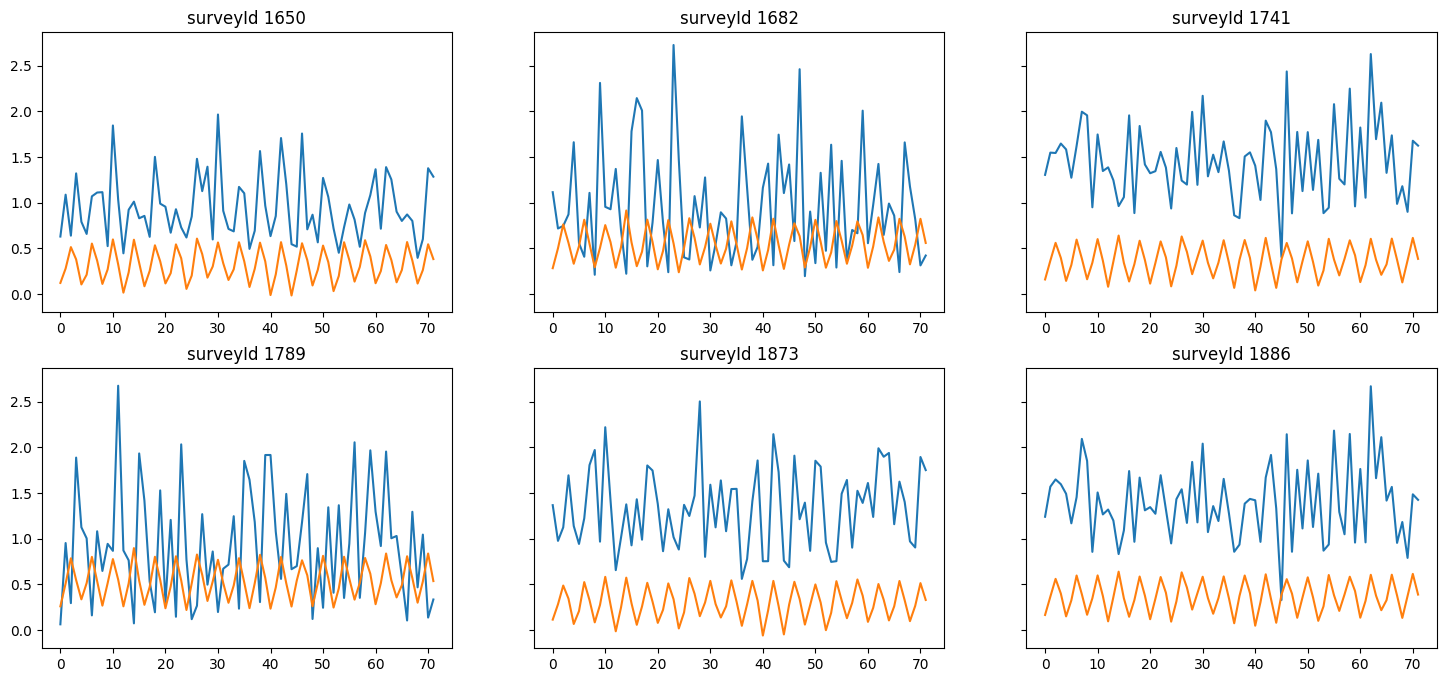

In [44]:
fig, axes = plt.subplots(2, 3, squeeze=False, sharey="all", figsize=[18,8])
id_im = 5*6
for idr, axr in enumerate(axes):
    for idc, ax in enumerate(axr):
        for ch in range(6, train_dataset[id_im][1].shape[0]):
            ax.plot(torch.transpose(train_dataset[id_im][1][ch], 1,0).numpy().reshape(-1))
        id_im += 1
        ax.set_title("surveyId %d"%train_dataset[id_im][4])
fig.show()

In [ ]:
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))

In [ ]:
train_metadata.speciesId.drop_duplicates().sort_values()
prev_min = 10
train_metadata.value_counts("speciesId").sort_index().pipe(lambda x: x[x>=prev_min])

In [ ]:
print(train_dataset[0][1].shape)
#val = np.zeros([len(train_dataset)])
#for i, d in enumerate(tqdm.tqdm(train_dataset)):
#    val[i] = torch.sum(torch.sum(torch.reshape(torch.permute(d[1], [0,2,1]), [6, -1]), -2) == 0).numpy()

In [ ]:
#plt.hist(val[val>0])

In [ ]:
patch_size = [1,16,16]
n_frame = 1
n_channel = 4
embed_dim = 1024
decoder_depth = 8
num_heads = 16
mlp_ratio = 4
head_dropout = 0.0
      
path_prithvi = "/home/gt/gdrive/codes_misc/prithvi/carbon_flux"
wt_file = os.path.join(path_prithvi, "Prithvi_EO_V2_300M_TL.pt")
if not os.path.isfile(wt_file):
  hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-EO-2.0-300M-TL", filename="Prithvi_EO_V2_300M_TL.pt", local_dir=path_prithvi)

prithvi_instance = PrithviViT(
        patch_size=patch_size,
        num_frames=n_frame,
        in_chans=n_channel,
        embed_dim=embed_dim,
        decoder_depth=decoder_depth,
        num_heads=num_heads,
        mlp_ratio=mlp_ratio,
        head_dropout=head_dropout,
        backbone_input_size=[1,64,64],
        encoder_only=False,
        padding=True,
)
prithvi_model = prithvi_terratorch(wt_file, prithvi_instance, [1,64,64])
prithvi_model.freeze_encoder()

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("DEVICE = CUDA")
prithvi_model.to(device);

In [ ]:
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet18, self).__init__()
        self.norm_input = nn.LayerNorm([8,4,18])
        self.resnet18 = models.resnet18(weights=None)
        # We have to modify the first convolutional layer to accept 4 channels instead of 3
        self.resnet18.conv1 = nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet18.maxpool = nn.Identity()
        self.ln = nn.LayerNorm(1000)
        #self.fc = nn.Linear(1000, 128)

    def forward(self, x):
        #x = self.norm_input(x)
        x = self.resnet18(x)
        x = self.ln(x)
        #x = self.fc(x)
        return x

class SimpleDecoder(nn.Module):
    def __init__(self, input_dim=[17,1024], hidden_dim=256, output_dim=128):
        super(SimpleDecoder, self).__init__()
        self.fc1 = nn.Linear(input_dim[1], hidden_dim) # 1024 to 256; shape 17x1024 to 10x256
        self.hidden_dim_flattened=input_dim[0] * hidden_dim #17 is feature dim+ class token in MAE; 17x256 to 4352
        self.fc2 = nn.Linear(self.hidden_dim_flattened, output_dim) # 4352 to 128
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x)) #shape 17x1024 to 17x256 ORG
        x = torch.reshape(x,(x.shape[0], x.shape[1]*x.shape[2])) #17x256 to 4352 
        x = self.fc2(x) # 4352 to 128 Output shape 
        return x

class ModifiedPrithviResNet18(nn.Module):
    def __init__(self, num_classes, prithvi_model):
        super(ModifiedPrithviResNet18, self).__init__()
        self.prithvi_model = prithvi_model
        self.decoder = SimpleDecoder(input_dim=[17,1024], hidden_dim=256, output_dim=128)
        self.landsat_part = ModifiedResNet18(num_classes)
        self.drop_tail = nn.Dropout(0.5)
        self.fc_tail = nn.Linear(1000 + 128, 1000 + 128)
        self.relu_tail = nn.ReLU()
        self.drop_last = nn.Dropout(0.5)
        self.fc_final = nn.Linear(1000 + 128, num_classes)
        #self.fc_final = nn.Linear(1000, num_classes)

    def forward(self, sentinel, landsat, lonlat=None):
        x = self.prithvi_model(sentinel, None, lonlat, torch.tensor(0, device=device))
        x0 = self.decoder(x)
        x1 = self.landsat_part(landsat)
        x = torch.concat([x0, x1], -1)
        x = self.drop_tail(x)
        x = self.fc_tail(x)
        x = self.relu_tail(x)
        x = self.drop_last(x)
        x = self.fc_final(x)
        #x = self.fc_final(x1)
        return x

In [ ]:
# Check if cuda is available
set_seed(69)
model = ModifiedPrithviResNet18(num_classes, prithvi_model).to(device)

In [ ]:
resNet18 = ModifiedResNet18(num_classes).to(device)
summary(resNet18, (6, 4, 18))

#summary(model.landsat_part, [(4, 1, 64, 64), (6, 4, 21)])
#list(model.fc_final.named_parameters())
#[name for name, p in model.named_parameters()]

In [ ]:
n = 10
sentinel_batch = torch.stack([train_dataset[i][0] for i in range(n)])[:,:,None,:,:]
landsat_batch = torch.stack([train_dataset[i][1] for i in range(n)])
lonlat_batch = torch.stack([train_dataset[i][2] for i in range(n)])
prithvi_res = prithvi_model.forward(sentinel_batch.to(device), None, lonlat_batch.to(device), torch.tensor(0, device=device))
print(prithvi_res.to(device).shape)
model_res = model.forward(sentinel_batch.to(device), landsat_batch.to(device), lonlat_batch.to(device))
print(model_res.shape)

In [ ]:
# Hyperparameters
learning_rate = 0.0002
weight_decay_tail = 1e-4
num_epochs = 100
positive_weigh_factor = 1.0

#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

tail_weight_names = ['fc_final.weight', 'fc_tail.weight']
last_layer_weights = [p for name, p in model.named_parameters() if any([par_tail_name in name for par_tail_name in tail_weight_names])]
others = [p for name, p in model.named_parameters() if not any([par_tail_name in name for par_tail_name in tail_weight_names])]
optim_dict = [{"params": others}, {"params": last_layer_weights, "weight_decay": weight_decay_tail}]
optimizer = torch.optim.AdamW(optim_dict, lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=25, verbose=True)

In [ ]:
tail_weight_names = ['fc_final.weight', 'fc_tail.weight']
[name for name, p in model.named_parameters() if any([par_tail_name in name for par_tail_name in tail_weight_names])]

In [ ]:
print(f"Training for {num_epochs} epochs started.")
model.eval()
loss_array = np.zeros(len(val_loader))
for batch_idx, (data_sentinel, data_landsat, data_lonlat, targets, _) in tqdm.tqdm(enumerate(val_loader), total=len(val_loader), leave=False):
    data_sentinel = data_sentinel.to(device)[:,:,None,:,:]
    data_landsat = data_landsat.to(device)
    data_lonlat = data_lonlat.to(device)
    targets = targets.to(device)
    outputs = model(data_sentinel, data_landsat, data_lonlat)
    pos_weight = targets * positive_weigh_factor
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    loss = criterion(outputs, targets)
    loss_array[batch_idx] = loss.item()
mean_val_loss = np.mean(loss_array)
print(f"Epoch {0}/{num_epochs}, train loss: NA, validation loss: {mean_val_loss:.6f}")

for epoch in range(num_epochs):
    model.train()
    loss_array = np.zeros(len(train_loader))
    for batch_idx, (data_sentinel, data_landsat, data_lonlat, targets, _) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        data_sentinel = data_sentinel.to(device)[:,:,None,:,:]
        data_landsat = data_landsat.to(device)
        data_lonlat = data_lonlat.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(data_sentinel, data_landsat, data_lonlat)
        pos_weight = targets * positive_weigh_factor
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = criterion(outputs, targets)
        loss_array[batch_idx] = loss.item()
        loss.backward()
        optimizer.step()
        # if batch_idx % 175 == 0:
        #     print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")
    mean_train_loss = np.mean(loss_array)
    
    model.eval()
    loss_array = np.zeros(len(val_loader))
    for batch_idx, (data_sentinel, data_landsat, data_lonlat, targets, _) in tqdm.tqdm(enumerate(val_loader), total=len(val_loader), leave=False):
        data_sentinel = data_sentinel.to(device)[:,:,None,:,:]
        data_landsat = data_landsat.to(device)
        data_lonlat = data_lonlat.to(device)
        targets = targets.to(device)
        outputs = model(data_sentinel, data_landsat, data_lonlat)
        pos_weight = targets * positive_weigh_factor
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = criterion(outputs, targets)
        loss_array[batch_idx] = loss.item()
    mean_val_loss = np.mean(loss_array)
        
    print(f"Epoch {epoch+1}/{num_epochs}, train loss: {mean_train_loss:.6f}, validation loss: {mean_val_loss:.6f}")
    scheduler.step()
    # print("Scheduler:",scheduler.state_dict())


In [ ]:
# Save the trained model
model.eval()
torch.save(model.state_dict(), "prithvi-frozen-resnet18-tail2.pth")

In [ ]:
most_train_countries = (train_metadata.country.value_counts().cumsum() / test_metadata.shape[0]).index[:10].values
model.eval()
with torch.no_grad():
    all_predictions = []
    surveys = []
    top_indices = []
    for data_sentinel, data_landsat, data_lonlat, surveyId in tqdm.tqdm(test_loader, total=len(test_loader)):
        data_sentinel = data_sentinel.to(device)[:,:,None,:,:]
        data_landsat = data_landsat.to(device)
        data_lonlat = data_lonlat.to(device)
        outputs = model(data_sentinel, data_landsat, data_lonlat)
        predictions = torch.sigmoid(outputs).cpu().numpy()
        # Sellect top-25 values as predictions
        top_batch = np.sort(np.argsort(-predictions, axis=1)[:, :25])
        top_batch_list = top_batch.tolist()
        surveyId = surveyId.numpy()
        #tmp_metadata = test_metadata.loc[test_metadata.surveyId.isin(surveyId)]
        #tmp_metadata.set_index("surveyId", inplace=True)
        #tmp_metadata = tmp_metadata.loc[surveyId]
        #tmp_metadata.reset_index(drop=True, inplace=True)
        #tmp_metadata = tmp_metadata.loc[~tmp_metadata.country.isin(most_train_countries)]
        #for i in tmp_metadata.index:
        #    top_batch_list[i] = np.sort(train_metadata.value_counts("speciesId").index[:1000].values.astype(int))

        top_indices += top_batch_list
        surveys.extend(surveyId)

In [ ]:
data_concatenated = [' '.join(map(str, row)) for row in top_indices]

pd.DataFrame(
    {'surveyId': surveys,
     'predictions': data_concatenated,
    }).to_csv("submission_prithvi-frozen_resnet18_drop05_regl2e2_e12.csv", index = False)

In [ ]:
plt.plot(np.log(np.sort(predictions[0,:]))[-100:])

In [ ]:
(train_metadata.country.value_counts().cumsum() / test_metadata.shape[0]).index[:10].values

In [ ]:
test_metadata.country.value_counts().cumsum() / test_metadata.shape[0]

In [ ]:
test_metadata.country.isin(most_train_countries).sum()

In [ ]:
train_metadata.head(20)

In [ ]:
test_metadata.loc[test_metadata.surveyId.isin(surveyID.numpy())]

In [ ]:
tmp_metadata

In [ ]:
top_25

In [ ]:
test_metadata.surveyId.isin(surveyID.numpy()).sum()

In [ ]:
surveyID

In [ ]:
plt.plot(np.log10(train_metadata.value_counts("speciesId").values))

In [ ]:
np.sort(train_metadata.value_counts("speciesId").index[:1000].values.astype(int))

In [ ]:
np.Inf